# Final Project Submission

* Students names: Cody Freese/Fennec Nightingale/Thomas Cornett
* Student pace: Part time
* Instructor name: Amber Yandow
* Blog post URL:

## Table Of Contents
<font size=3rem>
    
0 -**[ INTRO](#INTRODUCTION)<br>**
1 -**[ OBTAIN](#OBTAIN)**<br>
2 -**[ SCRUB](#SCRUB)**<br>
3 -**[ EXPLORE](#EXPLORE)**<br>
4 -**[ MODEL](#MODEL)**<br>
5 -**[ INTERPRET](#INTERPRET)**<br>
6 -**[ CONCLUSIONS & RECCOMENDATIONS](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

## Words go here lol

# OBTAIN

## Import tools

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import mlxtend

In [3]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
from math import sin, cos, sqrt, atan2, radians
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from scipy.stats import zscore
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn import svm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
#editing our settings so we can view more of our data at once 
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## King County dataset

In [6]:
#wrote up our data types to save on computer space and stop some of them from being inccorectly read as objs
kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 
             'floors': float, 'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 
             'yr_built': int, 'yr_renovated': float, 'zipcode': float, 'lat': float, 'long': float}

In [7]:
#read csv, parsing dates and using our dtypes 
kc_data = pd.read_csv(r'~\Documents\Flatiron\data\data\kc_house_data.csv', parse_dates = ['date'], dtype=kc_dtypes)

In [7]:
#have some errors in sqft_basement but I want to use it, so I've gotta replace the str, fill the null values 
# & add one sqft to each basement with no sqft, so that when we multiply to get rid of multi-colinieartiy 
#we don't end up multiplying by a bunch of zeroes and wrecking stuff 
kc_data['sqft_basement'] = kc_data['sqft_basement'].replace({'?': 0})
kc_data['sqft_basement'] = kc_data['sqft_basement'].fillna(0)
kc_data['sqft_basement'] = kc_data['sqft_basement'].astype(dtype=float)

i = 0 
for sqft in kc_data['sqft_basement']:
    if kc_data['sqft_basement'].iloc[i] == 0.0:
        kc_data['sqft_basement'].iloc[i] + 1.0

In [8]:
#getting rid of multicolinearity in sqftage 
kc_data['sqft_total'] = kc_data['sqft_living']*kc_data['sqft_lot']
kc_data['sqft_neighb'] = kc_data['sqft_living15']*kc_data['sqft_lot15']
kc_data['sqft_habitable'] = kc_data['sqft_above']*kc_data['sqft_basement']

In [9]:
#in our search for outliers we found some data that was likely just a typo, let's fix that 
kc_data[kc_data['bedrooms'] == 33] = kc_data[kc_data['bedrooms'] == 33].replace(33,3)

In [10]:
#setting waterfront NaN values equal to the ratio of waterfront/non-waterfront properties, will want to try and narrow by zipcode 
#filling NaN with easily seperatable/changable values helpful 
kc_data = kc_data.fillna(0)

In [11]:
#Convert to integer for whole number year, not sure why it'll let us reassign it here but raise errors in dtypes
kc_data['yr_renovated'] = kc_data['yr_renovated'].astype('int')
# fixing condition to be a good or bad, hoping that'll help get rid of the multicolinearity 
kc_data['condition'] = kc_data.condition.replace(to_replace = [1.0, 2.0, 3.0, 4.0, 5.0],  value= ['bad', 'bad', 'good', 'good', 'good'])

In [12]:
#making dummies of our catagorical variables 
dumm = pd.get_dummies(kc_data['condition'], drop_first=True)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['view'], prefix='view', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['grade'], prefix='gra', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

In [13]:
# renaming our dummies so that they'r easier to interpret 
kc_data = kc_data.rename({'view_1.0': 'view1', 'view_2.0': 'view2', 'view_3.0': 'view3', 'view_4.0':'view4'},axis=1)
kc_data = kc_data.rename({'gra_4': 'D', 'gra_5':'Cmin', 'gra_6':'C','gra_7':'Cpl', 'gra_8':'Bmin', 'gra_9':'B',
                          'gra_10':'Bpl', 'gra_11':'Amin', 'gra_12':'A', 'gra_13':'Apl'},axis=1)

In [14]:
#we have 70 zipcodes and 120 years, it would add too much complexity to our data to increase it by 190 columns
# so instead, we're going to go through and bin them! 
zips = []
years = []


for zipcode in kc_data.zipcode:
    zips.append(zipcode)
for year in kc_data.yr_built:
    years.append(year)
    
zips = list(set(zips))
years = list(set(years))

zips.sort()
years.sort()

In [15]:
#will have to find a way to write this into a loop at some point, but, I can't figure out how to get .replace()
#to adequatley read lists of lists while also giving them unique names, so for now this works 
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[0:5],  value= 'zip001t005')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[5:10], value= 'zip006t011')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[10:15], value= 'zip014t024')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[15:20], value= 'zip027t031')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[20:25], value= 'zip032t039')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[25:30], value= 'zip040t053')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[30:35], value= 'zip055t065')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[35:40], value= 'zip070t077')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[40:45], value= 'zip092t106')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[45:50], value= 'zip107t115')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[50:55], value= 'zip116t122')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[55:60], value= 'zip125t144')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[60:65], value= 'zip146t168')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[65:70], value= 'zip177t199')

In [16]:
#gonna do the same for year built by 20 years, will give us 6 new columns, may be illuminating 
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[0:20], value= 'thru20')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[20:40], value= 'thru40')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[40:60], value= 'thru60')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[60:80], value= 'thru80')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[80:100], value= 'thru2000')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[100:120], value= 'thru2020')

In [17]:
# get dummies of our new variables 
dumm = pd.get_dummies(kc_data['zipcode'], prefix=None, drop_first=True)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['yr_built'], prefix=None, drop_first=True)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

In [18]:
#sqrt trasnforming price so that it's more normalized 
kc_data['pricesqrt'] = kc_data['price'].apply(np.sqrt)

In [449]:
print(sqrt(17728447450.16226 ))
print(sqrt(19094035777.885963))

133148.21609831
138181.1701277926


In [19]:
#some of these homes don't have a full bathroom, as we're focusing on homes that would be sold to families
#wanting at least one full bathroom is a reasonable requirement. We also have a handful of homes with too 
#many bedrooms, while I'm sure some families want 10 bedrooms, 7 is probably a good stopping point there 
kc_data =  kc_data.loc[kc_data['bathrooms'] >= 1]
kc_data =  kc_data.loc[kc_data['bedrooms'] <= 7]
#drop unnessecary columns, print columns we will be using going forward 
to_drop = ['sqft_living','sqft_lot','id','date','sqft_above','sqft_basement', 'yr_built', 'condition', 'grade',
           'zipcode']
kc_data = kc_data.drop(labels=to_drop,axis=1)
kc_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_total', 'sqft_neighb', 'sqft_habitable', 'good', 'view1', 'view2', 'view3', 'view4', 'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'A', 'Apl', 'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80', 'pricesqrt'], dtype='object')

In [20]:
kc_data = kc_data[['pricesqrt', 'price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated',
                   'lat', 'long', 'sqft_neighb', 'sqft_total', 'sqft_habitable', 'good',
                   'view1', 'view2', 'view3', 'view4', 
                   'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'A', 'Apl', 
                   'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 
                   'zip055t065', 'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 
                   'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 
                   'thru2020', 'thru40', 'thru60', 'thru80']].copy()

In [21]:
kc_data.describe()

,pricesqrt,price,bedrooms,bathrooms,floors,waterfront,yr_renovated,lat,long,sqft_neighb,sqft_total,sqft_habitable,good,view1,view2,view3,view4,D,Cmin,C,Cpl,Bmin,B,Bpl,Amin,A,Apl,zip006t011,zip014t024,zip027t031,zip032t039,zip040t053,zip055t065,zip070t077,zip092t106,zip107t115,zip116t122,zip125t144,zip146t168,zip177t199,thru2000,thru2020,thru40,thru60,thru80
count,21499.000000,2.149900e+04,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,2.149900e+04,2.149900e+04,2.149900e+04,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.00000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.000000,21499.00000,21499.000000,21499.000000
mean,706.799139,5.406849e+05,3.371227,2.118901,1.495163,0.006558,68.608261,47.560084,-122.213901,2.880218e+07,3.569641e+07,4.915673e+05,0.991023,0.015257,0.044188,0.023536,0.014605,0.000651,0.010559,0.093493,0.416019,0.281827,0.121541,0.052700,0.018512,0.004093,0.000605,0.056468,0.051909,0.071817,0.080748,0.09419,0.088283,0.064189,0.074794,0.065259,0.086376,0.086097,0.060514,0.057956,0.209638,0.221080,0.07926,0.194149,0.229313
std,202.785132,3.668306e+05,0.883487,0.763481,0.539706,0.080720,363.656813,0.138606,0.140411,7.050291e+07,1.083524e+08,1.036406e+06,0.094324,0.122574,0.205518,0.151602,0.119970,0.025511,0.102214,0.291128,0.492908,0.449900,0.326762,0.223439,0.134798,0.063849,0.024583,0.230828,0.221849,0.258191,0.272454,0.29210,0.283713,0.245095,0.263065,0.246988,0.280925,0.280514,0.238443,0.233666,0.407059,0.414984,0.27015,0.395553,0.420401
min,279.284801,7.800000e+04,1.000000,1.000000,1.000000,0.000000,0.000000,47.155900,-122.519000,6.965700e+05,-1.965487e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,568.330890,3.230000e+05,3.000000,1.750000,1.000000,0.000000,0.000000,47.470850,-122.328000,8.553050e+06,8.412130e+06,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,670.820393,4.500000e+05,3.000000,2.250000,1.500000,0.000000,0.000000,47.571900,-122.230000,1.369704e+07,1.417926e+07,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,803.118920,6.450000e+05,4.000000,2.500000,2.000000,0.000000,0.000000,47.678100,-122.125000,2.192884e+07,2.462895e+07,6.966000e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,2774.887385,7.700000e+06,7.000000,8.000000,3.500000,1.000000,2015.000000,47.777600,-121.315000,2.979504e+09,2.146767e+09,3.886330e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


## Load Schools Info 

In [22]:
schools = pd.read_csv(r'~\Documents\Flatiron\data\data\Schools.csv')
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   X           642 non-null    float64
 1   Y           642 non-null    float64
 2   OBJECTID    642 non-null    int64  
 3   FEATURE_ID  642 non-null    int64  
 4   ESITE       642 non-null    int64  
 5   CODE        642 non-null    int64  
 6   NAME        642 non-null    object 
 7   ABB_NAME    642 non-null    object 
 8   ADDRESS     642 non-null    object 
 9   ZIPCODE     642 non-null    int64  
 10  LONG_CEN    642 non-null    float64
 11  LAT_CEN     642 non-null    float64
 12  SCH_CLASS   641 non-null    float64
 13  DISTRICT    641 non-null    object 
 14  PIN         641 non-null    float64
 15  MAJOR       641 non-null    float64
 16  MINOR       641 non-null    float64
 17  FEATUREDES  642 non-null    object 
 18  OSPI_CODE   606 non-null    float64
dtypes: float64(9), int64(5), obje

In [23]:
type(schools['LAT_CEN'].iloc[2])

numpy.float64

In [24]:
#calculate distance between schools and data 
kc = {}
kc5 = {}
# approximate radius of earth in miles  miles
i = 0
#iterate over each of our rows in the dataframe
while i <= 21498:
    R = 3963.0
    k = 0
    lat1 = radians(kc_data['lat'].iloc[i])
    lon1 = radians(kc_data['long'].iloc[i])
    distance = []
    #iterate over each school to see which school is the closest to each row in our datframe 
    while k <= 641:
        lat2 = radians(schools['LAT_CEN'].iloc[k])
        lon2 = radians(schools['LONG_CEN'].iloc[k])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance.append(R * c)
        
        k += 1 
    #sort schools by distance 
    distance.sort()
    #choose closest school 
    kc[i] = distance[0:1]
    #find some of distance to nearest 5 schools 
    kc5[i] = sum(distance[0:5])
    i += 1

In [25]:
kc1 = pd.DataFrame.from_dict(kc, orient='index', columns=['mi_nearest_scl'])
kc5 = pd.DataFrame.from_dict(kc5, orient='index', columns=['mi_5_scls'])

In [26]:
kc_data = kc_data.merge(kc1, left_index=True, right_index=True)
kc_data = kc_data.merge(kc5, left_index=True, right_index=True)

## Check for NaN

In [27]:
kc_data.isna().sum()

pricesqrt         0
price             0
bedrooms          0
bathrooms         0
floors            0
waterfront        0
yr_renovated      0
lat               0
long              0
sqft_neighb       0
sqft_total        0
sqft_habitable    0
good              0
view1             0
view2             0
view3             0
view4             0
D                 0
Cmin              0
C                 0
Cpl               0
Bmin              0
B                 0
Bpl               0
Amin              0
A                 0
Apl               0
zip006t011        0
zip014t024        0
zip027t031        0
zip032t039        0
zip040t053        0
zip055t065        0
zip070t077        0
zip092t106        0
zip107t115        0
zip116t122        0
zip125t144        0
zip146t168        0
zip177t199        0
thru2000          0
thru2020          0
thru40            0
thru60            0
thru80            0
mi_nearest_scl    0
mi_5_scls         0
dtype: int64

## For Loop - Value Counts

In [28]:
for col in kc_data.columns:
    try:
        print(col, kc_data[col].value_counts()[:5])
    except:
        print(col, kc_data[col].value_counts())
    print('\n')

pricesqrt 670.820393    171
591.607978    170
741.619849    158
707.106781    152
651.920241    150
             ... 
682.788401      1
855.920557      1
632.751926      1
842.911621      1
583.085757      1
Name: pricesqrt, Length: 3600, dtype: int64


price 450000.0    171
350000.0    170
550000.0    158
500000.0    152
425000.0    150
           ... 
575575.0      1
837700.0      1
575550.0      1
873000.0      1
884744.0      1
Name: price, Length: 3600, dtype: int64


bedrooms 3    9766
4    6850
2    2721
5    1591
6     271
Name: bedrooms, dtype: int64


bathrooms 2.50    5340
1.00    3850
1.75    3045
2.25    2038
2.00    1923
1.50    1441
2.75    1175
3.00     741
3.50     722
3.25     581
3.75     151
4.00     130
4.50      96
4.25      79
4.75      23
5.00      20
Name: bathrooms, dtype: int64


floors 1.0    10598
2.0     8144
1.5     1903
3.0      593
2.5      159
3.5        6
Name: floors, dtype: int64


waterfront 0.0    21263
1.0      140
Name: waterfront, dtype: int64


## Drop Condition Has No Values Present

## Summary

In [29]:
kc_data.describe().round(3)

,pricesqrt,price,bedrooms,bathrooms,floors,waterfront,yr_renovated,lat,long,sqft_neighb,sqft_total,sqft_habitable,good,view1,view2,view3,view4,D,Cmin,C,Cpl,Bmin,B,Bpl,Amin,A,Apl,zip006t011,zip014t024,zip027t031,zip032t039,zip040t053,zip055t065,zip070t077,zip092t106,zip107t115,zip116t122,zip125t144,zip146t168,zip177t199,thru2000,thru2020,thru40,thru60,thru80,mi_nearest_scl,mi_5_scls
count,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,2.140300e+04,2.140300e+04,2.140300e+04,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000,21403.000
mean,706.468,540100.168,3.371,2.116,1.492,0.007,68.916,47.560,-122.214,2.880249e+07,3.574061e+07,4.916697e+05,0.991,0.015,0.044,0.024,0.015,0.001,0.011,0.094,0.417,0.281,0.121,0.052,0.018,0.004,0.001,0.057,0.052,0.072,0.081,0.094,0.088,0.064,0.075,0.065,0.086,0.086,0.061,0.058,0.211,0.218,0.080,0.195,0.230,0.484,4.600
std,202.497,365893.440,0.883,0.763,0.538,0.081,364.442,0.139,0.140,7.042753e+07,1.084957e+08,1.035863e+06,0.095,0.123,0.205,0.152,0.120,0.026,0.102,0.292,0.493,0.450,0.326,0.223,0.134,0.064,0.025,0.231,0.222,0.258,0.273,0.292,0.283,0.245,0.263,0.247,0.281,0.280,0.239,0.234,0.408,0.413,0.271,0.396,0.421,0.460,3.651
min,279.285,78000.000,1.000,1.000,1.000,0.000,0.000,47.156,-122.519,6.965700e+05,-1.965487e+09,0.000000e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005,0.490
25%,567.450,322000.000,3.000,1.750,1.000,0.000,0.000,47.470,-122.328,8.571840e+06,8.434275e+06,0.000000e+00,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.245,2.921
50%,670.820,450000.000,3.000,2.250,1.500,0.000,0.000,47.572,-122.230,1.370511e+07,1.419840e+07,0.000000e+00,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.381,3.886
75%,803.119,645000.000,4.000,2.500,2.000,0.000,0.000,47.678,-122.125,2.194530e+07,2.464328e+07,6.996000e+05,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.575,5.180
max,2774.887,7700000.000,7.000,8.000,3.500,1.000,2015.000,47.778,-121.315,2.979504e+09,2.146767e+09,3.886330e+07,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,16.615,105.823


# EXPLORE

## Histogram

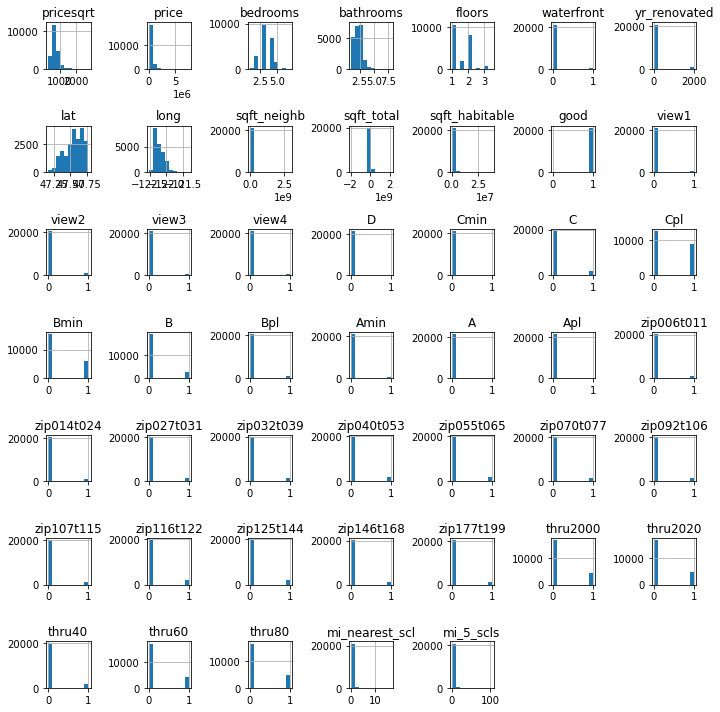

In [30]:
kc_data.hist(figsize=(10,10))
plt.tight_layout()

## Scatter Matrix

In [31]:
#fig = pd.plotting.scatter_matrix(kc_data,figsize=(30,30));
#print(type(fig))

## Heatmap

Text(0.5, 1.0, 'Correlations')

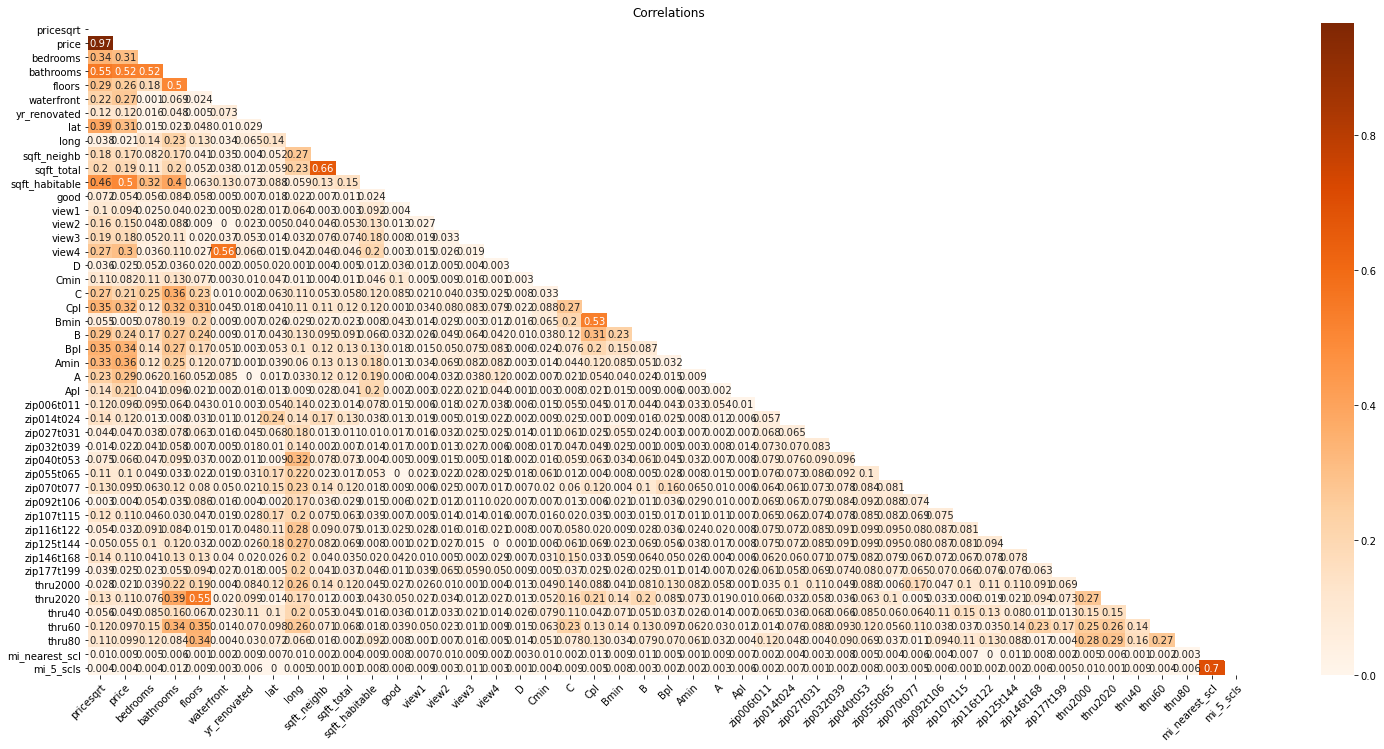

In [32]:
fig, ax = plt.subplots(figsize=(26,12))

corr = kc_data.corr().abs().round(3)

mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, mask=mask, cmap='Oranges', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Correlations')

# MODEL

## Initial Model on Price

In [281]:
outcome = 'pricesqrt'
x_cols = [ 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated', 
          'lat', 'long', 'sqft_neighb', 'sqft_total', 'sqft_habitable', 
          'good', 'view1', 'view2', 'view3', 'view4',
          'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'A', 'Apl', 
          'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
          'zip055t065', 'zip070t077', 'zip092t106', 
          'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
          'zip177t199', 
          'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80']

In [282]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pricesqrt   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     1361.
Date:                Fri, 11 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:36:44   Log-Likelihood:            -1.2128e+05
No. Observations:               20734   AIC:                         2.427e+05
Df Residuals:                   20693   BIC:                         2.430e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.423e+04    726.717    -19.576      0.000   -1.57e+04   -1.28e+04
bedrooms          12.7468      0.833     15.306      0.000      11.114      14.379
bathrooms         36.5761      1.380     26.504      0.000      33.871      39.281
floors             5.5719      1.676      3.325      0.001       2.287       8.857
waterfront       138.1928     12.123     11.400      0.000     114.432     161.954
yr_renovated       0.0066      0.002      3.779      0.000       0.003       0.010
lat              400.0101      4.841     82.632      0.000     390.522     409.499
long              21.0395      6.149      3.422      0.001       8.988      33.091
sqft_neighb     7.619e-08   1.24e-08      6.132      0.000    5.18e-08    1.01e-07
sqft_total      5.761e-08   8.24e-09      6.991      0.000    4.15e-08    7.38e-08
sqft_habitable   1.41e-05   9.23e-07     15.284      0.000    1.23e-05    1.59e-05
good              44.2175      6.188      7.146      0.000      32.089      56.346
view1             73.3331      5.012     14.631      0.000      63.509      83.158
view2             56.5652      3.025     18.702      0.000      50.637      62.494
view3             81.7369      4.359     18.751      0.000      73.193      90.281
view4            117.2433      7.114     16.480      0.000     103.298     131.188
D              -1807.8208     83.105    -21.753      0.000   -1970.714   -1644.928
Cmin           -1774.5084     80.696    -21.990      0.000   -1932.680   -1616.337
C              -1728.5983     80.683    -21.425      0.000   -1886.743   -1570.454
Cpl            -1666.2891     80.822    -20.617      0.000   -1824.707   -1507.871
Bmin           -1591.1411     80.920    -19.663      0.000   -1749.751   -1432.531
B              -1496.5179     80.935    -18.490      0.000   -1655.158   -1337.878
Bpl            -1426.4867     80.987    -17.614      0.000   -1585.228   -1267.745
Amin           -1366.5795     81.197    -16.830      0.000   -1525.732   -1207.427
A              -1367.9999     84.132    -16.260      0.000   -1532.905   -1203.094
Apl            -8.173e-13    4.4e-14    -18.589      0.000   -9.03e-13   -7.31e-13
zip006t011         7.2976      2.962      2.464      0.014       1.493      13.103
zip014t024       -61.0031      3.006    -20.296      0.000     -66.894     -55.112
zip027t031       -38.2480      2.648    -14.445      0.000     -43.438     -33.058
zip032t039       -21.9425      2.597     -8.450      0.000     -27.033     -16.853
zip055t065       -40.0009      2.480    -16.129      0.000     -44.862     -35.140
zip070t077       -26.6930      2.895     -9.220      0.000     -32.368     -21.018
zip092t106       -23.6879      2.937     -8.065      0.000     -29.445     -17.931
zip107t115         4.1914      3.250      1.290      0.197      -2.178      10.561
zip116t122  

## Regression Results

In [35]:
model.params.sort_values()

Intercept        -1.785229e+04
D                -2.127401e+03
Cmin             -2.094543e+03
C                -2.048977e+03
Cpl              -1.989521e+03
Bmin             -1.914441e+03
B                -1.805766e+03
Bpl              -1.698900e+03
Amin             -1.580695e+03
A                -1.431644e+03
Apl              -1.160404e+03
thru2000         -1.314783e+02
thru2020         -1.244579e+02
zip146t168       -1.112294e+02
thru80           -1.058107e+02
zip177t199       -7.908472e+01
zip125t144       -7.702760e+01
zip014t024       -6.867161e+01
zip070t077       -5.402534e+01
zip055t065       -5.402230e+01
zip027t031       -5.262343e+01
thru60           -4.950657e+01
zip092t106       -3.760515e+01
zip116t122       -3.057849e+01
zip032t039       -2.163284e+01
zip006t011       -1.345200e+01
thru40           -1.032297e+01
long             -5.017891e+00
zip107t115       -4.473619e+00
sqft_total        4.365034e-08
sqft_neighb       5.705920e-08
sqft_habitable    1.891593e-05
yr_renov

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              pricesqrt   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              7648.
Date:                Fri, 11 Dec 2020   Prob (F-statistic):                        0.00
Time:                        16:27:06   Log-Likelihood:                         -35966.
No. Observations:                5536   AIC:                                  7.198e+04
Df Residuals:                    5514   BIC:                                  7.212e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bd_bth_ratio     174.5930      3.332     52.394      0.000     168.060     181.126
floors           284.4882      3.126     90.996      0.000     278.359     290.617
waterfront        86.6684     26.265      3.300      0.001      35.180     138.157
lattrans         315.3097     30.457     10.353      0.000     255.602     375.017
sqft_neighb     1.664e-07   3.24e-08      5.131      0.000    1.03e-07     2.3e-07
sqft_total      9.142e-08   1.92e-08      4.752      0.000    5.37e-08    1.29e-07
sqft_habitable  5.698e-05   1.92e-06     29.680      0.000    5.32e-05    6.07e-05
view1             82.6792     13.006      6.357      0.000      57.182     108.176
view2             81.7471      8.030     10.180      0.000      66.005      97.489
view3            101.0673     10.656      9.485      0.000      80.178     121.957
view4            110.8541     15.087      7.347      0.000      81.277     140.431
zip014t024       -75.2845     22.308     -3.375      0.001    -119.017     -31.552
zip027t031       -11.0735      9.584     -1.155      0.248     -29.862       7.715
zip055t065        -2.6717     11.701     -0.228      0.819     -25.610      20.267
zip092t106       -29.9604      8.587     -3.489      0.000     -46.794     -13.126
zip116t122       -31.9845      7.382     -4.333      0.000     -46.457     -17.512
zip125t144       -43.2145     10.400     -4.155      0.000     -63.603     -22.826
zip146t168       -25.7969     16.877     -1.529      0.126     -58.883       7.289
zip177t199         3.0824     10.367      0.297      0.766     -17.241      23.406
thru40            31.2566      7.843      3.985      0.000      15.882      46.632
thru60           113.3617      7.050     16.080      0.000      99.541     127.182
mi_nearest_scl    38.2153      3.947      9.681      0.000      30.477      45.954
==============================================================================
Omnibus:                      190.765   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.354
Skew:                          -0.243   Prob(JB):                     1.55e-83
Kurtosis:                       4.190   Cond. No.                     2.68e+09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.68e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[('bd_bth_ratio', 6.550569243063864),
 ('floors', 6.40089027723153),
 ('waterfront', 1.3083797127777672),
 ('lattrans', 2.0306975851565037),
 ('sqft_neighb', 2.3713123054500334),
 ('sqft_total', 2.19141714160536),
 ('sqft_habitable', 1.5274225529909018),
 ('view1', 1.0672778494648625),
 ('view2', 1.1681387001636336),
 ('view3', 1.1339533858999946),
 ('view4', 1.356887733276828),
 ('zip014t024', 1.1942802413781732),
 ('zip027t031', 1.1769153015074698),
 ('zip055t065', 1.1871235501585051),
 ('zip092t106', 1.2216024107358945),
 ('zip116t122', 1.282634196712491),
 ('zip125t144', 1.1848447471960477),
 ('zip146t168', 1.1135792110296334),
 ('zip177t199', 1.2438962345534557),
 ('thru40', 1.3499768873084521),
 ('thru60', 1.5293701668775272),
 ('mi_nearest_scl', 1.8070876376847218)]

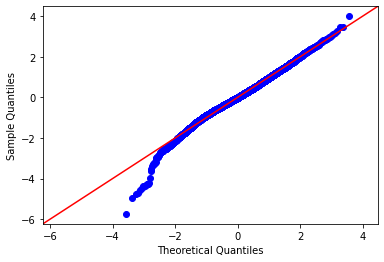

In [224]:
lowtier = kc_data[kc_data.price <=300000]
midtier = kc_data[(kc_data.price > 300001) & (kc_data.price<=800000) ]
hightier = kc_data[(kc_data.price > 600000)]

lowincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront','yr_renovated',
           'lat', 'long', 'sqft_neighb', 'sqft_total', 'sqft_habitable', 'good', 
           'view1', 'view2', 'view3', 'view4', 
           'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'A', 'Apl', 
           'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 
           'zip055t065', 'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 
           'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 
           'thru2020', 'thru40', 'thru60', 'thru80']

mediumincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated',
           'lat', 'long', 'sqft_neighb', 'sqft_total', 'sqft_habitable',  'good', 
           'view1', 'view2', 'view3', 'view4', 
           'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'A', 'Apl', 
           'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 
           'zip055t065', 'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 
           'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 
           'thru2020', 'thru40', 'thru60', 'thru80']

highincome = ['bd_bth_ratio', 'floors', 'waterfront',
           'lattrans', 'sqft_neighb', 'sqft_total', 'sqft_habitable',  
           'view1', 'view2', 'view3', 'view4', 
           'zip014t024', 'zip027t031', 'zip055t065', 'zip092t106', 'zip116t122', 
           'zip125t144', 'zip146t168', 'zip177t199',
           'thru40', 'thru60', 'mi_nearest_scl']

def make_ols(df, x_columns, drops=None, target='pricesqrt', add_constant=False):
    if drops:
        drops.append(target)
        X = df.drop(columns=drops)
    else:
        X = df[x_columns]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    display(res.summary())
    fig = sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)
    return res
#make_ols(lowtier,lowincome)
#make_ols(midtier,mediumincome)
make_ols(hightier,highincome)
X = hightier[highincome]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(highincome, vif))

## Refinement

In [37]:
kc_columns = ['price']

In [38]:
for col in kc_columns:
    col_zscore = str(col + '_zscore')
    kc_data[col_zscore] = (kc_data[col] - kc_data[col].mean())/kc_data[col].std()
    kc_data = kc_data.loc[kc_data[col_zscore] < 2.25]
    kc_data = kc_data.loc[kc_data[col_zscore] > (-2.25)]
    kc_data = kc_data.drop(col_zscore, axis = 1)

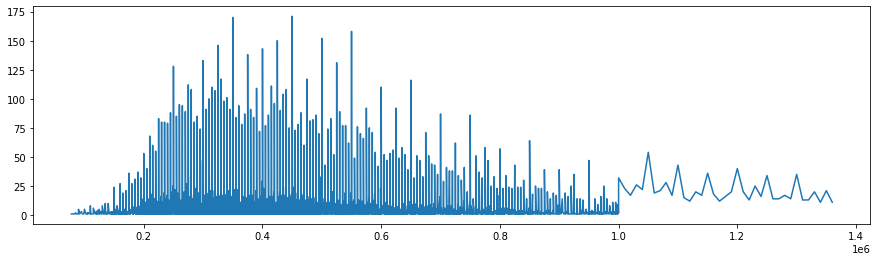

In [39]:
plt.figure(figsize=(15,4))
plt.plot(kc_data['price'].value_counts().sort_index())

In [40]:
for i in range(1,100):
    q = i / 100
    print('{} percentile: {}'.format(q, kc_data['price'].quantile(q=q)))

0.01 percentile: 154648.5
0.02 percentile: 175000.0
0.03 percentile: 190500.0
0.04 percentile: 201000.0
0.05 percentile: 210000.0
0.06 percentile: 219000.0
0.07 percentile: 225000.0
0.08 percentile: 232000.0
0.09 percentile: 239291.0
0.1 percentile: 245000.0
0.11 percentile: 250000.0
0.12 percentile: 254950.0
0.13 percentile: 260000.0
0.14 percentile: 265000.0
0.15 percentile: 269950.0
0.16 percentile: 275000.0
0.17 percentile: 279490.25
0.18 percentile: 284000.0
0.19 percentile: 289950.0
0.2 percentile: 294979.4
0.21 percentile: 299950.0
0.22 percentile: 303000.0
0.23 percentile: 309000.0
0.24 percentile: 314000.0
0.25 percentile: 319000.0
0.26 percentile: 324000.0
0.27 percentile: 327000.0
0.28 percentile: 330000.0
0.29 percentile: 335928.5
0.3 percentile: 340000.0
0.31 percentile: 346000.0
0.32 percentile: 350000.0
0.33 percentile: 355000.0
0.34 percentile: 360000.0
0.35 percentile: 365000.0
0.36 percentile: 370000.0
0.37 percentile: 375000.0
0.38 percentile: 380000.0
0.39 percentil

In [444]:
kc_data['flr'] = kc_data['floors']-kc_data['floors'].mean()
kc_data['bth*bd'] = kc_data['bathrooms']*kc_data['bedrooms']
kc_data['near_scl_comp'] = kc_data['mi_nearest_scl']-kc_data['mi_nearest_scl'].mean()
kc_data['near_5_scl_comp'] = kc_data['mi_5_scls']-kc_data['mi_5_scls'].mean()
kc_data['lattrans'] = kc_data['lat']-kc_data['lat'].mean()
kc_data.columns

Index(['pricesqrt', 'price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated', 'lat', 'long', 'sqft_neighb', 'sqft_total', 'sqft_habitable', 'good', 'view1', 'view2', 'view3', 'view4', 'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'A', 'Apl', 'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80', 'mi_nearest_scl', 'mi_5_scls', 'bd_bth_ratio', 'lattrans', 'longtrans', 'bd', 'bth', 'flr', 'nearest_scl_comp', 'near_scl_comp', 'near_5_scl_comp', 'bd*flr', 'bth*flr', 'bth*bd'], dtype='object')

In [381]:
#test vifs 
test = kc_data[['waterfront', 'yr_renovated', 'lat', 'long', 'sqft_neighb', 'sqft_total', 'sqft_habitable', 'good', 'view1', 'view2', 'view3', 'view4', 'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'A', 'Apl', 'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80', 'lattrans', 'longtrans', 'bd', 'bth', 'flr', 'nearest_scl_comp', 'near_5_scl_comp']]
test_cols = ['waterfront', 'yr_renovated', 'lat', 'long', 'sqft_neighb', 'sqft_total', 'sqft_habitable', 'good', 'view1', 'view2', 'view3', 'view4', 'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'A', 'Apl', 'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80', 'lattrans', 'longtrans', 'bd', 'bth', 'flr', 'nearest_scl_comp']
X = test[test_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(test_cols, vif))

[('waterfront', 1.3076685986511092),
 ('yr_renovated', 1.0904945142977667),
 ('lat', 225179981368524.8),
 ('long', 5525889113338.032),
 ('sqft_neighb', 2.031692225114145),
 ('sqft_total', 1.9964060055900168),
 ('sqft_habitable', 1.5515762032121256),
 ('good', 1.0254471555370652),
 ('view1', 1.0274374023807469),
 ('view2', 1.0636756709311026),
 ('view3', 1.0603910529538847),
 ('view4', 1.3274279699444396),
 ('D', inf),
 ('Cmin', 9007199254740992.0),
 ('C', inf),
 ('Cpl', inf),
 ('Bmin', inf),
 ('B', 9007199254740992.0),
 ('Bpl', 3002399751580330.5),
 ('Amin', inf),
 ('A', inf),
 ('Apl', nan),
 ('zip006t011', 2.096011012974976),
 ('zip014t024', 1.9466304392948444),
 ('zip027t031', 2.340230288618369),
 ('zip032t039', 2.4457018059595352),
 ('zip040t053', 2.8615999532536898),
 ('zip055t065', 2.581596313243416),
 ('zip070t077', 2.509559213815482),
 ('zip092t106', 2.4232821259201147),
 ('zip107t115', 2.4331100504362166),
 ('zip116t122', 2.8609474006652826),
 ('zip125t144', 2.8477498838162085)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              pricesqrt   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              9149.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        08:30:11   Log-Likelihood:                         -31277.
No. Observations:                5417   AIC:                                  6.261e+04
Df Residuals:                    5390   BIC:                                  6.279e+04
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
sqft_neighb       5.022e-08   4.37e-08      1.148      0.251   -3.55e-08    1.36e-07
sqft_total        3.042e-07   4.54e-08      6.697      0.000    2.15e-07    3.93e-07
sqft_habitable     -1.6e-05   3.07e-06     -5.209      0.000    -2.2e-05   -9.98e-06
view3               53.7653     15.814      3.400      0.001      22.764      84.766
zip006t011         163.5206     10.032     16.300      0.000     143.854     183.188
zip014t024         119.6535      4.550     26.296      0.000     110.733     128.574
zip027t031         135.9204      4.836     28.104      0.000     126.439     145.402
zip032t039         143.5489      5.077     28.272      0.000     133.595     153.503
zip040t053         134.4290      5.431     24.751      0.000     123.781     145.076
zip055t065         158.6379      4.498     35.268      0.000     149.820     167.456
zip070t077         194.1642     10.556     18.394      0.000     173.471     214.857
zip092t106         160.1303      4.819     33.229      0.000     150.683     169.578
zip107t115         231.5558      8.388     27.605      0.000     215.112     248.000
zip116t122         275.4402      5.815     47.368      0.000     264.041     286.840
zip125t144         228.2843      5.469     41.741      0.000     217.563     239.006
zip146t168         166.9725      5.021     33.253      0.000     157.129     176.816
zip177t199         138.9642      5.105     27.222      0.000     128.957     148.972
thru2000           306.5956      4.751     64.534      0.000     297.282     315.909
thru2020           314.1201      5.225     60.124      0.000     303.878     324.362
thru40             287.7466      5.881     48.925      0.000     276.217     299.276
thru60             291.5657      4.458     65.405      0.000     282.827     300.305
thru80             300.2719      4.497     66.773      0.000     291.456     309.088
lattrans           -74.5494     10.114     -7.371      0.000     -94.377     -54.722
longtrans           39.5133     11.289      3.500      0.000      17.383      61.644
bth*bd              12.0786      0.467     25.841      0.000      11.162      12.995
flr                -31.6245      3.225     -9.806      0.000     -37.947     -25.302
nearest_scl_comp    -0.2401      0.243     -0.989      0.323      -0.716       0.236
==============================================================================
Omnibus:                     1607.169   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6127.183
Skew:                           1.436   Prob(JB):                         0.00
Kurtosis:                       7.347   Cond. No.                     6.86e+08
=======================================

[('sqft_neighb', 2.1578431674001854),
 ('sqft_total', 2.1696300570035434),
 ('sqft_habitable', 1.7895548440060909),
 ('view3', 1.0261760579096775),
 ('zip006t011', 1.172926496548441),
 ('zip014t024', 1.9270140156296345),
 ('zip027t031', 1.792974265017578),
 ('zip032t039', 1.8661759159839477),
 ('zip040t053', 2.0191452679609183),
 ('zip055t065', 2.2715731689073593),
 ('zip070t077', 1.2070774077641533),
 ('zip092t106', 1.6543712380363629),
 ('zip107t115', 1.189553396286267),
 ('zip116t122', 1.287632889820392),
 ('zip125t144', 2.145555809821429),
 ('zip146t168', 2.3672565445670353),
 ('zip177t199', 1.7195660141191242),
 ('thru2000', 4.60527770457393),
 ('thru2020', 3.8397313620710354),
 ('thru40', 1.623829439552782),
 ('thru60', 4.162186304562199),
 ('thru80', 5.145009016543988),
 ('lattrans', 2.726682097998489),
 ('longtrans', 1.974635356638617),
 ('bth*bd', 8.414202576405916),
 ('flr', 2.4161142356336405),
 ('nearest_scl_comp', 1.0041049112415044)]

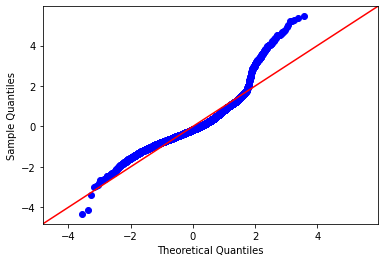

In [445]:
lowtier = kc_data[(kc_data.price > 210000) & (kc_data.price<=348000) ]
midtier = kc_data[(kc_data.price > 348000) & (kc_data.price<=480000) ]
uppermidtier = kc_data[(kc_data.price > 480000) & (kc_data.price<=664000) ]
hightier = kc_data[(kc_data.price >664000) & (kc_data.price<=1080000)]

lowincome = ['sqft_neighb', 'sqft_total', 'sqft_habitable', 
             'view3', 'zip006t011', 
             'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 'zip055t065',
             'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 'zip125t144', 
             'zip146t168', 'zip177t199', 'thru2000', 'thru2020', 'thru40', 'thru60', 
             'thru80', 'lattrans', 'longtrans', 'bth*bd', 'flr', 'nearest_scl_comp']


mediumincome = ['bathrooms', 'lat', 'long', 
                'sqft_neighb', 'sqft_habitable',  
                'view2', 'Cpl', 'Bmin', 'B', 'Bpl', 
                'zip006t011', 'zip014t024', 'zip040t053', 
                'zip070t077', 'zip107t115', 'zip116t122', 
                'zip146t168', 'thru2000', 
                'thru2020', 'thru60', 'thru80']

uppermedincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 
                  'lat', 'long', 'sqft_neighb', 'sqft_habitable', 
                  'D',  'Bmin', 'B', 'Bpl', 'Amin', 
                  'zip027t031', 'zip032t039', 'zip055t065',  
                  'zip125t144', 'zip146t168',  'thru2000', 
                  'thru2020', 'thru80', 'mi_5_scls']

highincome = ['bedrooms', 'bathrooms', 'waterfront', 'yr_renovated',
              'sqft_neighb','good',
              'Cmin','C', 'Cpl',  'B', 'Bpl', 'Amin', 
              'zip006t011', 'zip014t024', 'zip032t039', 'zip040t053', 
              'zip055t065', 'zip092t106', 'zip107t115', 'zip116t122', 
              'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 
              'thru2020', 'thru40', 'thru60', 'thru80', 
              'mi_nearest_scl', 'mi_5_scls']

def make_ols(df, x_columns, drops=None, target='pricesqrt', add_constant=False):
    if drops:
        drops.append(target)
        X = df.drop(columns=drops)
    else:
        X = df[x_columns]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    res = ols.fit()
    display(res.summary())
    fig = sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)
    return res


make_ols(lowtier,lowincome)
# make_ols(midtier,mediumincome)
# make_ols(uppermidtier,uppermedincome)
# make_ols(hightier,highincome)
X = lowtier[lowincome]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(lowincome, vif))

## Train Split Test - High Tier

In [155]:
print(type(hightier))
kc_data.columns
highincome

<class 'pandas.core.frame.DataFrame'>


['bedrooms',
 'bathrooms',
 'waterfront',
 'yr_renovated',
 'sqft_neighb',
 'good',
 'Cmin',
 'C',
 'Cpl',
 'B',
 'Bpl',
 'Amin',
 'zip006t011',
 'zip014t024',
 'zip032t039',
 'zip040t053',
 'zip055t065',
 'zip092t106',
 'zip107t115',
 'zip116t122',
 'zip125t144',
 'zip146t168',
 'zip177t199',
 'thru2000',
 'thru2020',
 'thru40',
 'thru60',
 'thru80',
 'mi_nearest_scl',
 'mi_5_scls']

In [366]:
y = hightier[['pricesqrt']].copy()
X = hightier[['bedrooms', 'bathrooms', 'waterfront', 'yr_renovated',
              'sqft_neighb','good',
              'Cmin','C', 'Cpl',  'B', 'Bpl', 'Amin', 
              'zip006t011', 'zip014t024', 'zip032t039', 'zip040t053', 
              'zip055t065', 'zip092t106', 'zip107t115', 'zip116t122', 
              'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 
              'thru2020', 'thru40', 'thru60', 'thru80', 
              'mi_nearest_scl', 'mi_5_scls']].copy()

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [368]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

2236 1492 2236 1492


In [369]:
print(X_train)

       bedrooms  bathrooms  waterfront  yr_renovated  sqft_neighb  good  Cmin  C  Cpl  B  Bpl  Amin  zip006t011  zip014t024  zip032t039  zip040t053  zip055t065  zip092t106  zip107t115  zip116t122  zip125t144  zip146t168  zip177t199  thru2000  thru2020  thru40  thru60  thru80  mi_nearest_scl   mi_5_scls
9262          4       2.75         0.0             0     45588000     1     0  0    0  1    0     0           0           0           1           0           0           0           0           0           0           0           0         1         0       0       0       0        0.436104    5.485365
6017          4       2.50         0.0             0     40615380     1     0  0    0  1    0     0           0           0           0           0           0           0           0           0           0           1           0         0         0       0       0       1        0.977589    7.986436
4095          4       3.00         0.0             0     48348000     1     0  0    0  1

In [370]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [371]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [372]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: pricesqrt    2690.443535
dtype: float64
Test Mean Squarred Error: pricesqrt    2850.053951
dtype: float64


In [373]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 2690.4435345828956
Test Mean Squarred Error: 2850.053950510638


In [374]:
linreg.score(X_test, y_test)

0.1756639225602784

## Train Split Test - Medium Tier

In [225]:
y = m[['pricesqrt']]
X = kc_data.drop(['price', 'pricesqrt'], axis=1)

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [227]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

16587 4147 16587 4147


In [228]:
#print(X_train)

In [229]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [230]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [231]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: pricesqrt    7065.1992
dtype: float64
Test Mean Squarred Error: pricesqrt    6989.794952
dtype: float64


In [232]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)
print('Diff:', test_mse-train_mse)

Train Mean Squarred Error: 7065.199199959113
Test Mean Squarred Error: 6989.794951608692
Diff: -75.40424835042086


In [233]:
linreg.score(X_test, y_test)

0.728940558368089

## Train Split Test - Low Tier

In [450]:
y = lowtier[['price']].copy()
X = lowtier[['bth', 'flr', 'lattrans', 'sqft_neighb', 'sqft_habitable','view3', 
             'Cmin', 'Cpl', 'Bmin', 'Bpl', 'zip032t039', 'zip055t065', 'zip070t077', 'zip092t106', 
             'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 'thru2000', 
             'thru2020', 'thru40', 'thru60']].copy()

In [451]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [452]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

3521 1896 3521 1896


In [453]:
#print(X_train)

In [454]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [455]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [456]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: price    1.031317e+09
dtype: float64
Test Mean Squarred Error: price    1.058737e+09
dtype: float64


In [457]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 1031317247.0812349
Test Mean Squarred Error: 1058736547.9719138


In [8]:
print(sqrt(1031317247.0812349))
print(sqrt(1058736547.9719138))

32114.128465229052
32538.232096595442


In [425]:
linreg.score(X_test, y_test)

0.2569429471163234

In [426]:
x_cols =['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'sqft_neighb', 'sqft_total', 'sqft_habitable',
       'con2', 'con3', 'con4', 'con5', 'view1', 'view2', 'view3', 'view4',
       'grd4', 'grd5', 'grd6', 'grd7', 'grd8', 'grd9', 'grd10', 'grd11',
       'grd12', 'grd13']

In [364]:
X = kc_data[highincome]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(highincome, vif))

[('bedrooms', 22.238620783731324),
 ('bathrooms', 22.80010072201536),
 ('waterfront', 1.0173578739345273),
 ('yr_renovated', 1.116910907987602),
 ('sqft_neighb', 1.3072897785880795),
 ('good', 38.62064387490949),
 ('Cmin', 1.0891464459738425),
 ('C', 1.692477178598042),
 ('Cpl', 2.8051226191086047),
 ('B', 1.4874198934894556),
 ('Bpl', 1.2472987920337038),
 ('Amin', 1.0887953842063187),
 ('zip006t011', 1.3015089452967548),
 ('zip014t024', 1.3025107669629905),
 ('zip032t039', 1.4219440655530629),
 ('zip040t053', 1.468957144608297),
 ('zip055t065', 1.4925163373164232),
 ('zip092t106', 1.4810792583072827),
 ('zip107t115', 1.4877397188916621),
 ('zip116t122', 1.6492970877990036),
 ('zip125t144', 1.6092025601619986),
 ('zip146t168', 1.4636002121539835),
 ('zip177t199', 1.389471147502795),
 ('thru2000', 5.353205348413832),
 ('thru2020', 5.490063866000917),
 ('thru40', 2.090487675307127),
 ('thru60', 4.055438275967958),
 ('thru80', 5.345839401604461),
 ('mi_nearest_scl', 4.123339746872709),
 

# Interpret

In [73]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pricesqrt   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     1721.
Date:                Fri, 11 Dec 2020   Prob (F-statistic):               0.00
Time:                        15:40:12   Log-Likelihood:            -1.2842e+05
No. Observations:               21403   AIC:                         2.569e+05
Df Residuals:                   21361   BIC:                         2.573e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.785e+04    843.071    -21.175      0.000   -1.95e+04   -1.62e+04
bedrooms          11.9086      0.946     12.592      0.000      10.055      13.762
bathrooms         44.5802      1.531     29.116      0.000      41.579      47.581
floors             7.0054      1.877      3.732      0.000       3.326      10.685
waterfront       239.4659     10.131     23.637      0.000     219.608     259.324
yr_renovated       0.0111      0.002      5.778      0.000       0.007       0.015
lat              416.2491      5.579     74.613      0.000     405.314     427.184
long              -5.0179      7.076     -0.709      0.478     -18.888       8.852
sqft_neighb     5.706e-08    1.3e-08      4.374      0.000    3.15e-08    8.26e-08
sqft_total      4.365e-08   8.35e-09      5.228      0.000    2.73e-08       6e-08
sqft_habitable  1.892e-05   8.28e-07     22.848      0.000    1.73e-05    2.05e-05
good              40.0159      7.153      5.594      0.000      25.996      54.036
view1             83.7987      5.521     15.179      0.000      72.978      94.619
view2             57.4551      3.364     17.078      0.000      50.861      64.049
view3             89.3148      4.593     19.444      0.000      80.311      98.318
view4            145.0142      6.957     20.845      0.000     131.379     158.650
D              -2127.4008     87.371    -24.349      0.000   -2298.655   -1956.147
Cmin           -2094.5432     84.203    -24.875      0.000   -2259.588   -1929.499
C              -2048.9771     84.161    -24.346      0.000   -2213.939   -1884.016
Cpl            -1989.5215     84.311    -23.597      0.000   -2154.777   -1824.266
Bmin           -1914.4405     84.423    -22.677      0.000   -2079.916   -1748.965
B              -1805.7664     84.440    -21.385      0.000   -1971.276   -1640.257
Bpl            -1698.9003     84.546    -20.094      0.000   -1864.616   -1533.184
Amin           -1580.6949     84.785    -18.644      0.000   -1746.879   -1414.510
A              -1431.6437     85.213    -16.801      0.000   -1598.667   -1264.621
Apl            -1160.4041     88.435    -13.122      0.000   -1333.743    -987.065
zip006t011       -13.4520      3.339     -4.029      0.000     -19.997      -6.907
zip014t024       -68.6716      3.463    -19.831      0.000     -75.459     -61.884
zip027t031       -52.6234      3.036    -17.334      0.000     -58.574     -46.673
zip032t039       -21.6328      2.931     -7.380      0.000     -27.378     -15.888
zip055t065       -54.0223      2.848    -18.965      0.000     -59.606     -48.439
zip070t077       -54.0253      3.287    -16.436      0.000     -60.468     -47.582
zip092t106       -37.6052      3.342    -11.252      0.000     -44.156     -31.054
zip107t115        -4.4736      3.653     -1.225      0.221     -11.634       2.686
zip116t122  

In [74]:
pd.set_option('display.max_rows', None)

In [75]:
kc_data = model.sort_values('coef', ascending=False)
kc_data.head(15)

AttributeError: 'OLSResults' object has no attribute 'sort_values'

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='grade', y='price', data=df_renovated)
ax.set(title='Grade relationship on Price', 
       xlabel='Grade', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bathrooms', y='price', data=df_renovated)
ax.set(title='Bathrooms & Price', 
       xlabel='Bathrooms', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bedrooms', y='price', data=df_renovated)
ax.set(title='Bedrooms & Price', 
       xlabel='Bedrooms', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='floors', y='price', data=df_renovated)
ax.set(title='Floors & Price', 
       xlabel='Floors', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='condition', y='price', data=df_renovated)
ax.set(title='Condition & Price', 
       xlabel='Condition', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_living', y='price', data=df_renovated)
ax.set(title='Square Feet Living Space & Price', 
       xlabel='SqFt.', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_above', y='price', data=df_renovated)
ax.set(title='Square Feet Above & Price', 
       xlabel='Sqft. Above', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_built', y='price', data=df_renovated)
ax.set(title='Year Built & Price', 
       xlabel='Year Built', ylabel='Price')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_renovated', y='price', data=df_renovated)
ax.set(title='Year Renovated & Price', 
       xlabel='Year', ylabel='Price')

fig.tight_layout()

In [ ]:
df_renovated=data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_renovated['pairs'] = list(zip(df_renovated.level_0,df_renovated.level_1)
df_renovated.set_index(['pairs'], inplace = True)
df_renovated.drop(columns=['level_1','level_0'], inplace = True)
df_renovated.columns = ['cc']
df.drop_ducplicates(inplace=True)

In [ ]:
df_renovated[(df.cc>.75) & (df.cc <1)]

# Conclusions & Recommendations

In [ ]:
mean_squared_error(y_train, predprice)